In [1]:
#importer les packages nécessaires
import pandas as pd
import numpy as np

#les packages de visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#importer les packages de préparation de données
from sklearn.preprocessing import StandardScaler

#importer les packages de clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak.*")
warnings.filterwarnings('ignore', category=FutureWarning)

1) Importer les données

In [2]:
df = pd.read_csv("fromage.csv") 
df.head(3)

,Fromages,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium
0,CarredelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20
1,Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27
2,Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41


2) Construire Z, la matrice centrée réduite de X 

In [3]:
#selectionne tout les col numérique
# X = df.iloc[:,1:] ou bien
# Mettre 'Fromages' comme index + le supprime
X = df.set_index('Fromages')
# normalisé
scaler = StandardScaler()
Z = scaler.fit_transform(X)
Z = pd.DataFrame(Z, columns=X.columns,index=X.index)
Z.head(3)

,calories,sodium,calcium,lipides,retinol,folates,proteines,cholesterol,magnesium
Fromages,,,,,,,,,
CarredelEst,0.154630,1.342968,-1.587464,0.268066,-0.672290,1.500911,0.121519,-0.165242,-0.626309
Babybel,0.154630,0.261393,0.337679,0.117846,-0.162662,-0.573843,0.355480,-0.165242,0.003101
Beaufort,1.117917,-0.918507,1.033649,1.144354,-0.533301,-1.025253,0.940383,1.636269,1.261920


 3) Construire Y en appliquant sur Z une ACP normée à 2 composantes 

In [4]:
pca = PCA(n_components=2)
Y = pca.fit_transform(Z)
Y = pd.DataFrame(Y, columns=['PC1', 'PC2'],index=X.index)
Y.head(3)

,PC1,PC2
Fromages,,
CarredelEst,-0.641901,1.802787
Babybel,0.472445,-0.333176
Beaufort,2.928683,-1.049375


4) Appliquer sur Y la classe KMeans de la bibliothèque sklearn pour regrouper les individus 
en 3 clusters. Afficher les coordonnées de chaque centroïde et l’inertie associée

In [5]:
# Initialisation du modèle KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++')
# Application du clustering sur les données Y
kmeans.fit(Y)

centroids = kmeans.cluster_centers_  
print("\nCentroids coordonné:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: {centroid} ")

#somme des distance à centroid carré
inertia = kmeans.inertia_
print(f"\nInertie: {inertia:.2f}")

#associe chaque individus à son cluster
Y['Cluster_k=3'] = kmeans.labels_
print(Y.head(3))


Centroids coordonné:
Cluster 0: [ 1.73762475 -0.67067984] 
Cluster 1: [-0.38791224  1.27327892] 
Cluster 2: [-4.48354372 -1.64012728] 

Inertie: 42.38
                  PC1       PC2  Cluster_k=3
Fromages                                    
CarredelEst -0.641901  1.802787            1
Babybel      0.472445 -0.333176            0
Beaufort     2.928683 -1.049375            0


5) Afficher les étiquettes des individus en sortie ainsi que le nombre d’individus de chaque classe

In [6]:
print("Répartition des individus par cluster :")
# Boucle sur les 3 clusters (0, 1, 2)
for cluster_num in range(3):
    # 1. Filtrage des individus appartenant au cluster actuel
    cluster_data = Y[Y['Cluster_k=3'] == cluster_num]
    # 2. Récupération des identifiants/noms des individus du cluster
    individus_cluster = cluster_data.index.tolist()
    # 3. Calcul du nombre d'individus dans le cluster
    nombre_individus = len(cluster_data)
    # Affichage des résultats pour le cluster
    print(f"\nCluster {cluster_num} :")
    print(f"- Liste des individus : {individus_cluster}")
    print(f"- Effectif : {nombre_individus} individus")

Répartition des individus par cluster :

Cluster 0 :
- Liste des individus : ['Babybel', 'Beaufort', 'Cantal', 'Cheddar', 'Comte', 'Edam', 'Emmental', 'Maroilles', 'Morbier', 'Parmesan', 'Pyrenees', 'SaintPaulin', 'Vacherin']
- Effectif : 13 individus

Cluster 1 :
- Liste des individus : ['CarredelEst', 'Bleu', 'Camembert', 'Chabichou', 'Chaource', 'Coulomniers', 'Fr.chevrepatemolle', 'Fr.fondu.45', 'PontlEveque', 'Reblochon', 'Rocquefort', 'Tome']
- Effectif : 12 individus

Cluster 2 :
- Liste des individus : ['Fr.frais20nat.', 'Fr.frais40nat.', 'Petitsuisse40', 'Yaourtlaitent.nat.']
- Effectif : 4 individus


6) Représenter graphiquement Y ainsi que les centres des clusters.

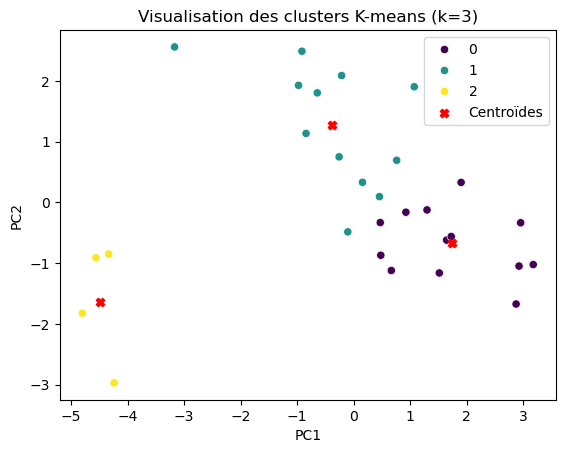

In [7]:
scatter = sns.scatterplot(
    x='PC1', 
    y='PC2',
    hue='Cluster_k=3',
    data=Y,
    palette ='viridis'
)

centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0], 
    centers[:, 1],
    c='red',
    marker='X',
    label='Centroïdes'
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualisation des clusters K-means (k=3)')
plt.legend()
plt.show()

7) Afficher les distances des individus aux centres des clusters

In [8]:
centroids = kmeans.cluster_centers_ 

points = Y[['PC1', 'PC2']].values
clusters = Y['Cluster_k=3'].values
# For each point, select its corresponding centroid
point_centroids = centroids[clusters]
# Calculate Euclidean distances
distances = np.sqrt(np.sum((points - point_centroids)**2, axis=1))
# Assign distances back to DataFrame
Y['Distance_centre'] = distances
Y.head(3)

,PC1,PC2,Cluster_k=3,Distance_centre
Fromages,,,,
CarredelEst,-0.641901,1.802787,1,0.587273
Babybel,0.472445,-0.333176,0,1.309423
Beaufort,2.928683,-1.049375,0,1.249812


8) Evaluer la qualité des regroupements lorsque k varie entre 2 et 6 en se basant sur la 
méthode de coude (Elbow Method) puis sur la méthode de silhouette. Déduire K optimal 

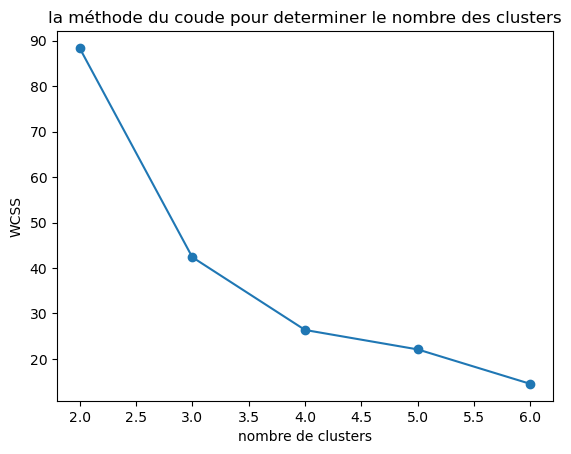

In [9]:
# within cluster sum of squares
wcss = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters= i, init= 'k-means++')
    kmeans.fit(Y[['PC1', 'PC2']])
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2, 7), wcss, marker='o')
plt.title('la méthode du coude pour determiner le nombre des clusters')
plt.xlabel('nombre de clusters')
plt.ylabel('WCSS')
plt.show()

méthode de coude => k=3

méthode de silhouette o il baki mta3 il tp makrinahech
ama takafa 3amma : 
Le score silhouette varie entre -1 et 1. Plus il est proche de 1, plus les clusters sont bien séparés et compacts.Tu choisis le nombre de clusters qui maximise ce score

mta3 cah
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


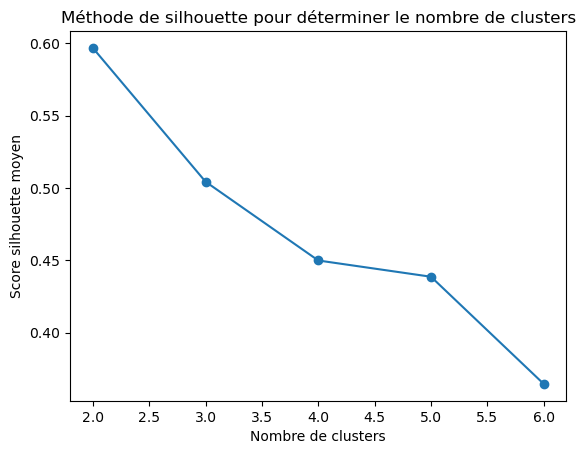

In [12]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

silhouette_scores = []
range_n_clusters = range(2, 7)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(Y[['PC1', 'PC2']])
    silhouette_avg = silhouette_score(Y[['PC1', 'PC2']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Affichage
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Méthode de silhouette pour déterminer le nombre de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score silhouette moyen')
plt.show()


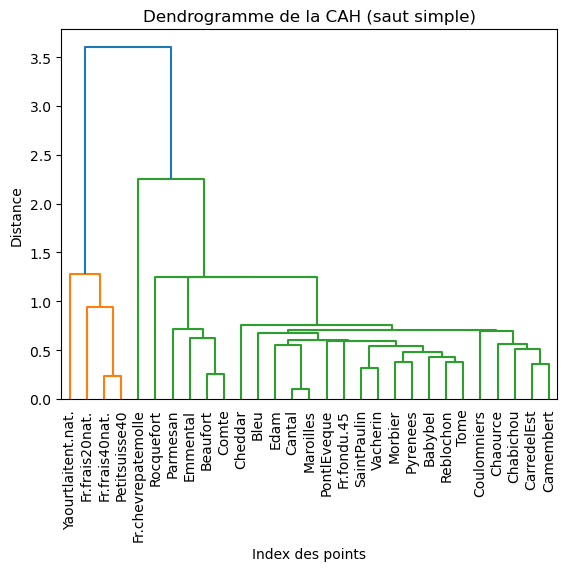

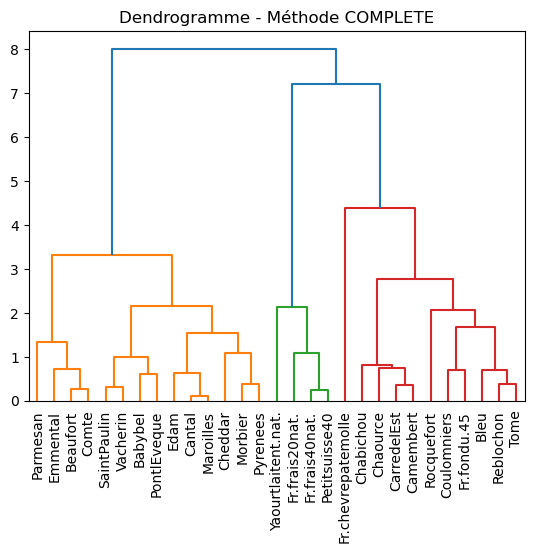

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Génération de la matrice des liens 'linkage simple'
# l'autre méthode et complete
Z = linkage(Y[['PC1', 'PC2']], method='single')

# Affichage du dendrogramme
plt.title("Dendrogramme de la CAH (saut simple)")
dendrogram(Z, labels=Y.index.tolist(), leaf_rotation=90)
plt.xlabel('Index des points')
plt.ylabel('Distance')
plt.show()

Z_complete = linkage(Y[['PC1', 'PC2']], method='complete')
plt.title("Dendrogramme - Méthode COMPLETE")
dendrogram(Z_complete, labels=Y.index.tolist(), leaf_rotation=90)
plt.show()

Observations et leurs groupes (4 classes):
                  PC1       PC2  Cluster_4_classes
Fromages                                          
CarredelEst -0.641901  1.802787                  3
Babybel      0.472445 -0.333176                  1
Beaufort     2.928683 -1.049375                  1
Bleu         0.763345  0.692700                  3
Camembert   -0.974337  1.926358                  3

Observations et leurs groupes (découpage à distance=7):
                  PC1       PC2  Cluster_distance_7
Fromages                                           
CarredelEst -0.641901  1.802787                   3
Babybel      0.472445 -0.333176                   1
Beaufort     2.928683 -1.049375                   1
Bleu         0.763345  0.692700                   3
Camembert   -0.974337  1.926358                   3


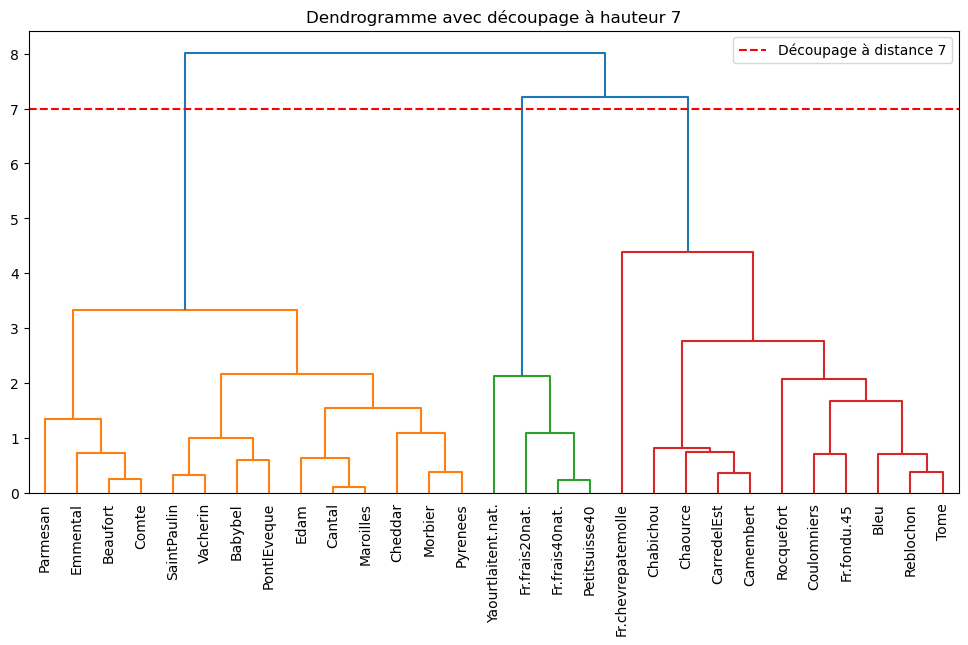

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Générer la matrice des liens
Z = linkage(Y[['PC1', 'PC2']], method='complete')

# Découpage en 4 classes
clusters_4 = fcluster(Z, t=4, criterion='maxclust')
Y['Cluster_4_classes'] = clusters_4  # Ajout des clusters dans le DataFrame

print("Observations et leurs groupes (4 classes):")
print(Y[['PC1', 'PC2', 'Cluster_4_classes']].head())

# Découpage à une hauteur distance = 7
clusters_dist7 = fcluster(Z, t=7, criterion='distance')
Y['Cluster_distance_7'] = clusters_dist7

print("\nObservations et leurs groupes (découpage à distance=7):")
print(Y[['PC1', 'PC2', 'Cluster_distance_7']].head())

# 4️⃣ Affichage du dendrogramme avec ligne horizontale (hauteur=7)
plt.figure(figsize=(12, 6))
plt.title("Dendrogramme avec découpage à hauteur 7")
dendrogram(Z, labels=Y.index.tolist(), leaf_rotation=90)
plt.axhline(y=7, color='red', linestyle='--', label='Découpage à distance 7')
plt.legend()
plt.show()
